<a href="https://colab.research.google.com/github/Elyz-ra/Sistem-Rekomendasi-Penjurusan-SMA/blob/main/Sistem_Rekomendasi_penjurusan_SMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Deskripsi Dataset

Dataset ini berisi informasi nilai akademik dari 608 siswa SMPN 2 Wungu yang telah lulus antara tahun 2021 hingga 2023. Setiap baris dalam dataset merepresentasikan satu siswa, dengan kolom-kolom yang mencakup data identitas serta nilai akademik pada berbagai mata pelajaran selama enam semester (kelas 7 hingga kelas 9 SMP).

Data ini diperoleh dari buku induk siswa, yang merupakan arsip resmi sekolah mengenai pencapaian akademik tiap peserta didik.

Berikut adalah struktur kolom dalam dataset:

| No. | Kategori           | Nama Kolom                        | Jumlah Kolom |
|-----|--------------------|-----------------------------------|--------------|
| 1   | Identitas Siswa    | Nama, NIS, Absen, Ekstrakurikuler | 4            |
| 2   | Pendidikan Agama   | Agama1 - Agama6                   | 6            |
| 3   | PPKn               | PKN1 - PKN6                       | 6            |
| 4   | Bahasa Indonesia   | Indo1 - Indo6                     | 6            |
| 5   | Matematika         | Mate1 - Mate6                     | 6            |
| 6   | IPA                | IPA1 - IPA6                       | 6            |
| 7   | IPS                | IPS1 - IPS6                       | 6            |
| 8   | Bahasa Inggris     | Inggris1 - Inggris6               | 6            |
| 9   | Seni Budaya        | Senbud1 - Senbud6                 | 6            |
| 10  | PJOK               | PJOK1 - PJOK6                     | 6            |
| 11  | Prakarya           | Prakarya1 - Prakarya6             | 6            |
| 12  | Bahasa Daerah      | B_Daerah1 - B_Daerah6             | 6            |
|     | **Total**          |                                   | **70**       |


#2. Import Library

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import linregress
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

#3. Memuat Dataset

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Jumlah data dummy yang akan ditambahkan
total_dummy = 400
ipa_target = 200
bahasa_target = 200

# Semua mata pelajaran yang ada di struktur
pelajaran = ['Agama', 'PKN', 'Indo', 'Mate', 'IPA', 'IPS', 'Inggris',
             'Senbud', 'PJOK', 'Prakarya', 'B_Daerah']

# Fungsi untuk membuat data dummy
def generate_dummy_siswa(jurusan, jumlah):
    data = []
    for i in range(jumlah):
        if jurusan == 'IPA':
            nis = np.random.randint(5000, 5999)
        else:  # Bahasa
            nis = np.random.randint(7001, 7999)

        row = {
            'Nama': f'Dummy_{jurusan}_{i+1}',
            'NIS': nis,
            'Absen': np.random.randint(1, 32),
            'Ekstrakurikuler': np.random.choice(['Pramuka', 'PMR', 'Keagamaan'])
        }

        for pel in pelajaran:
            for sem in range(1, 6+1):
                col = f"{pel}{sem}"
                if jurusan == 'IPA' and pel in ['IPA', 'Mate']:
                    row[col] = np.random.randint(80, 96)  # Nilai tinggi
                elif jurusan == 'Bahasa' and pel in ['Indo', 'Inggris']:
                    row[col] = np.random.randint(80, 96)
                else:
                    row[col] = np.random.randint(60, 86)  # Nilai umum
        data.append(row)
    return pd.DataFrame(data)

# Generate data dummy
ipa_dummy = generate_dummy_siswa('IPA', ipa_target)
bahasa_dummy = generate_dummy_siswa('Bahasa', bahasa_target)

# Gabungkan kedua dummy
dummy_data = pd.concat([ipa_dummy, bahasa_dummy], ignore_index=True)

# Tampilkan 5 baris pertama sebagai contoh
dummy_data.head()

,Nama,NIS,Absen,Ekstrakurikuler,Agama1,Agama2,Agama3,Agama4,Agama5,Agama6,...,Prakarya3,Prakarya4,Prakarya5,Prakarya6,B_Daerah1,B_Daerah2,B_Daerah3,B_Daerah4,B_Daerah5,B_Daerah6
0,Dummy_IPA_1,5102,20,Pramuka,74,70,67,80,66,85,...,68,85,80,61,79,74,66,71,67,74
1,Dummy_IPA_2,5034,14,Pramuka,63,77,67,63,61,65,...,69,66,85,68,66,68,67,71,61,60
2,Dummy_IPA_3,5047,23,Keagamaan,83,64,62,71,67,81,...,82,84,66,60,60,84,84,79,72,68
3,Dummy_IPA_4,5258,7,PMR,67,68,64,60,78,69,...,75,75,60,68,65,75,62,79,63,78
4,Dummy_IPA_5,5345,3,Keagamaan,78,79,66,79,68,60,...,75,84,62,84,77,73,77,61,81,62


Data asli terdiri dari 608 siswa dengan distribusi jurusan tidak seimbang:

| Jurusan | Jumlah |
| ------- | ------ |
| IPS     | 342    |
| IPA     | 139    |
| Bahasa  | 116    |

Agar model klasifikasi tidak bias terhadap jurusan mayoritas (IPS), diperlukan penambahan data untuk jurusan minoritas.

### A. Solusi
Ditambahkan 400 data dummy:
- 200 data jurusan IPA
- 200 data jurusan Bahasa

Total data setelah penambahan:

| Tipe Data  | Jumlah   |
| ---------- | -------- |
| Data Asli  | 608      |
| Data Dummy | 400      |
| **Total**  | **1008** |

### B.  Aturan Data Dummy
- IPA → nilai tinggi pada IPA & Matematika
- Bahasa → nilai tinggi pada Bahasa Indonesia & Bahasa Inggris
- Nilai lain diacak antara 60–85
- NIS unik, tidak tumpang tindih dengan data asli

### C. Tujuan
- Menyeimbangkan data antar jurusan
- Meningkatkan performa model klasifikasi
- Menghindari bias ke jurusan dominan (IPS)

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRxbz3oIGpsWYx-0ZW5vXA2TMO2TxzZkgwYVZSeTJkHoXJBhXzyhbc6bQw47vuB8Asq5TRXlKUGVvkp/pub?output=csv'
df_asli = pd.read_csv(url)

# Gabungkan dengan data dummy yang sudah dibuat sebelumnya (dummy_data)
df = pd.concat([df_asli, dummy_data], ignore_index=True)

# Simpan ke CSV (disimpan di Colab environment)
df.to_csv("data_akademik_gabungan.csv", index=False)

# tampilan 5 data teratas
df.head()


,Nama,NIS,Absen,Ekstrakurikuler,Agama1,Agama2,Agama3,Agama4,Agama5,Agama6,...,Prakarya3,Prakarya4,Prakarya5,Prakarya6,B_Daerah1,B_Daerah2,B_Daerah3,B_Daerah4,B_Daerah5,B_Daerah6
0,ADYTIA OKY ROMADONA,6160,12,Pramuka,76,82,72.0,78.0,72.0,81.0,...,76.0,77.0,73.0,76.0,74,65,67.0,72.0,74.0,77.0
1,AHMAD KHORINI,6161,12,"Pramuka, Keagamaan",78,82,80.0,80.0,74.0,81.0,...,74.0,76.0,70.0,76.0,69,72,69.0,69.0,71.0,76.0
2,AHMAT PUTRA ADITIA,6162,46,"Pramuka, Keagamaan",76,77,70.0,78.0,72.0,80.0,...,78.0,78.0,71.0,72.0,71,66,70.0,68.0,71.0,71.0
3,AIKA SALSABILLA,6163,18,"Pramuka, Keagamaan",80,81,75.0,78.0,83.0,84.0,...,80.0,81.0,77.0,78.0,74,73,68.0,72.0,74.0,80.0
4,AJENG APRILIA,6164,5,Pramuka,80,90,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,67,67,NaN,NaN,NaN,NaN


#4. Exploratory Data Analysis

## A. Missing Value & Duplicated Data

In [ ]:
df.isna().sum()

,0
Nama,0
NIS,0
Absen,0
Ekstrakurikuler,4
Agama1,0
...,...
B_Daerah2,0
B_Daerah3,2
B_Daerah4,4
B_Daerah5,4


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.drop_duplicates()
df.head()

,Nama,NIS,Absen,Ekstrakurikuler,Agama1,Agama2,Agama3,Agama4,Agama5,Agama6,...,Prakarya3,Prakarya4,Prakarya5,Prakarya6,B_Daerah1,B_Daerah2,B_Daerah3,B_Daerah4,B_Daerah5,B_Daerah6
0,ADYTIA OKY ROMADONA,6160,12,Pramuka,76,82,72.0,78.0,72.0,81.0,...,76.0,77.0,73.0,76.0,74,65,67.0,72.0,74.0,77.0
1,AHMAD KHORINI,6161,12,"Pramuka, Keagamaan",78,82,80.0,80.0,74.0,81.0,...,74.0,76.0,70.0,76.0,69,72,69.0,69.0,71.0,76.0
2,AHMAT PUTRA ADITIA,6162,46,"Pramuka, Keagamaan",76,77,70.0,78.0,72.0,80.0,...,78.0,78.0,71.0,72.0,71,66,70.0,68.0,71.0,71.0
3,AIKA SALSABILLA,6163,18,"Pramuka, Keagamaan",80,81,75.0,78.0,83.0,84.0,...,80.0,81.0,77.0,78.0,74,73,68.0,72.0,74.0,80.0
4,AJENG APRILIA,6164,5,Pramuka,80,90,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,67,67,NaN,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df.head()

,Nama,NIS,Absen,Ekstrakurikuler,Agama1,Agama2,Agama3,Agama4,Agama5,Agama6,...,Prakarya3,Prakarya4,Prakarya5,Prakarya6,B_Daerah1,B_Daerah2,B_Daerah3,B_Daerah4,B_Daerah5,B_Daerah6
0,ADYTIA OKY ROMADONA,6160,12,Pramuka,76,82,72.0,78.0,72.0,81.0,...,76.0,77.0,73.0,76.0,74,65,67.0,72.0,74.0,77.0
1,AHMAD KHORINI,6161,12,"Pramuka, Keagamaan",78,82,80.0,80.0,74.0,81.0,...,74.0,76.0,70.0,76.0,69,72,69.0,69.0,71.0,76.0
2,AHMAT PUTRA ADITIA,6162,46,"Pramuka, Keagamaan",76,77,70.0,78.0,72.0,80.0,...,78.0,78.0,71.0,72.0,71,66,70.0,68.0,71.0,71.0
3,AIKA SALSABILLA,6163,18,"Pramuka, Keagamaan",80,81,75.0,78.0,83.0,84.0,...,80.0,81.0,77.0,78.0,74,73,68.0,72.0,74.0,80.0
5,ANDIKA YUWANDA,6165,6,"Pramuka, Keagamaan",76,72,70.0,77.0,73.0,81.0,...,70.0,73.0,71.0,71.0,67,66,67.0,71.0,71.0,73.0


## B. Eksplorasi data distribusi

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 1006
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Nama             999 non-null    object 
 1   NIS              999 non-null    int64  
 2   Absen            999 non-null    int64  
 3   Ekstrakurikuler  999 non-null    object 
 4   Agama1           999 non-null    int64  
 5   Agama2           999 non-null    int64  
 6   Agama3           999 non-null    float64
 7   Agama4           999 non-null    float64
 8   Agama5           999 non-null    float64
 9   Agama6           999 non-null    float64
 10  PKN1             999 non-null    int64  
 11  PKN2             999 non-null    int64  
 12  PKN3             999 non-null    float64
 13  PKN4             999 non-null    float64
 14  PKN5             999 non-null    float64
 15  PKN6             999 non-null    float64
 16  Indo1            999 non-null    int64  
 17  Indo2            999

In [ ]:
df.shape

(999, 70)

In [ ]:
df['NIS'].nunique()

959

In [ ]:
df['Absen'].describe()

,Absen
count,999.000000
mean,12.375375
std,10.238941
min,0.000000
25%,4.000000
50%,10.000000
75%,19.000000
max,71.000000


In [ ]:
df['Ekstrakurikuler'].value_counts()

,count
Ekstrakurikuler,
"Pramuka, Keagamaan",500
Pramuka,178
Keagamaan,138
PMR,128
"Pramuka, Olah Raga, Keagamaan",14
"Pramuka, PMR, Keagamaan",14
"Pramuka, K. Ilmiah, Keagamaan",7
"Pramuka, PMR",6
"Pramuka, KEL. Ilmiah, Keagamaan",3


## C. Corelation Matrix

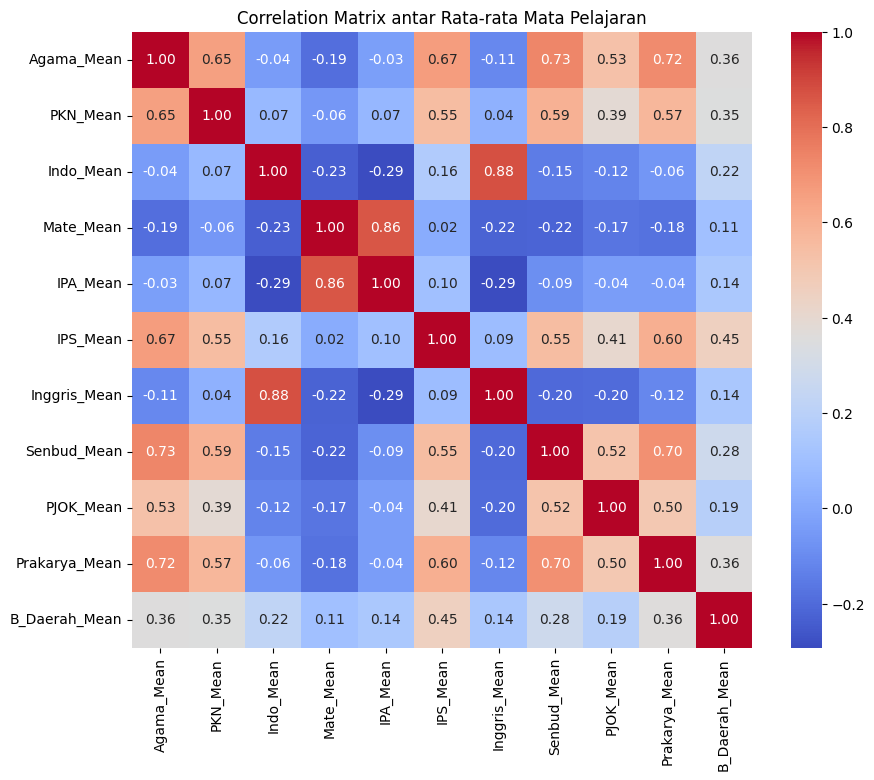

In [ ]:
subjects = ['Agama', 'PKN', 'Indo', 'Mate', 'IPA', 'IPS', 'Inggris', 'Senbud', 'PJOK', 'Prakarya', 'B_Daerah']

# Menghitung rata-rata setiap mata pelajaran
for subject in subjects:
    subject_cols = [col for col in df.columns if col.startswith(subject)]
    df[f'{subject}_Mean'] = df[subject_cols].mean(axis=1)

mean_cols = [f'{subject}_Mean' for subject in subjects]

correlation_matrix = df[mean_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix antar Rata-rata Mata Pelajaran')
plt.show()

### Analisis Correlation Matrix

1. Kelompok Mata Pelajaran dengan Korelasi Positif Kuat:
  Agama, PKN, IPS, Senbud, Prakarya, dan B_Daerah menunjukkan korelasi positif yang kuat (0.5-0.73). Hal ini mengindikasikan bahwa siswa yang memiliki nilai tinggi di satu mata pelajaran cenderung juga memiliki nilai tinggi di mata pelajaran lainnya dalam kelompok ini. Misalnya:
  - Agama dan Senbud (0.73)
  - Agama dan Prakarya (0.72)
  - PKN dan IPS (0.55)
  - Prakarya dan IPS (0.60)

  Insight: Mata pelajaran ini mungkin memiliki karakteristik serupa dalam metode pembelajaran atau penilaian (misalnya, lebih banyak menghafal atau berbasis proyek).

2. Kelompok Mata Pelajaran dengan Korelasi Negatif atau Lemah:
  Matematika (Mate_Mean) dan IPA (IPA_Mean) memiliki korelasi negatif atau sangat lemah dengan hampir semua mata pelajaran lain, kecuali dengan diri mereka sendiri (korelasi sempurna 1.00) dan korelasi kuat antara Matematika dan IPA (0.86). Ini menunjukkan bahwa siswa yang unggul di Matematika/IPA belum tentu unggul di mata pelajaran lain, dan sebaliknya.

  Contoh: Mate_Mean dan Indo_Mean (-0.24), Mate_Mean dan Senbud_Mean (-0.22).

  Insight: Matematika dan IPA mungkin membutuhkan keterampilan logika atau analitis yang berbeda dari mata pelajaran lain.

3. Korelasi Unik Bahasa Inggris dan Bahasa Indonesia:
  Inggris_Mean dan Indo_Mean memiliki korelasi sangat kuat (0.88), tetapi keduanya justru berkorelasi negatif/lemah dengan sebagian besar mata pelajaran lain (kecuali B_Daerah). Misalnya:
  - Inggris_Mean dan Agama_Mean (-0.11)
  - Indo_Mean dan IPA_Mean (-0.29)

  Insight: Kemampuan bahasa (baik Indonesia maupun Inggris) mungkin berdiri sendiri atau dipengaruhi faktor eksternal (misalnya, minat baca atau lingkungan).

4. Pola Keterkaitan PJOK (Pendidikan Jasmani):
  PJOK_Mean memiliki korelasi moderat dengan mata pelajaran non-akademik seperti Senbud (0.51) dan Prakarya (0.50), tetapi lemah dengan mata pelajaran akademik seperti Matematika/IPA.

  Insight: PJOK mungkin lebih terkait dengan keterampilan kinestetik atau kreativitas, bukan kemampuan kognitif murni.

5. Peran B_Daerah (Bahasa Daerah):
  B_Daerah_Mean memiliki korelasi positif moderat dengan hampir semua mata pelajaran (terutama IPS, PKN, dan Prakarya), tetapi tidak terlalu kuat dengan Matematika/IPA.

  Insight: Bahasa Daerah mungkin dipengaruhi oleh faktor budaya atau sosial yang juga terkait dengan mata pelajaran humaniora.

**Kesimpulan Utama:**

  Terdapat dua kelompok dominan:
  - Humaniora/Sosial (Agama, PKN, IPS, Senbud, Prakarya) dengan korelasi positif kuat.
  - Sains/Logika (Matematika, IPA) yang cenderung terisolasi dari kelompok lain.
  - Bahasa (Indonesia dan Inggris) membentuk kelompok tersendiri dengan pola unik.
  - PJOK dan B_Daerah lebih terkait dengan mata pelajaran non-teknis.

## D. Boxplot

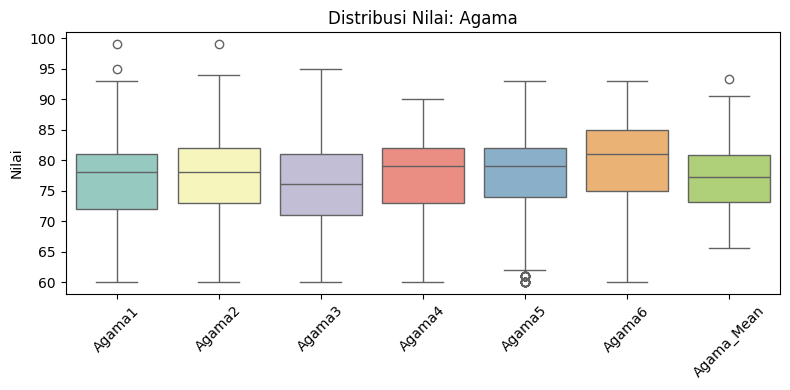

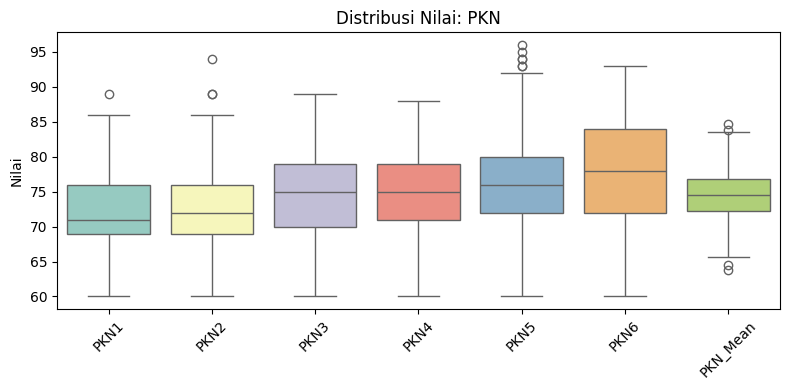

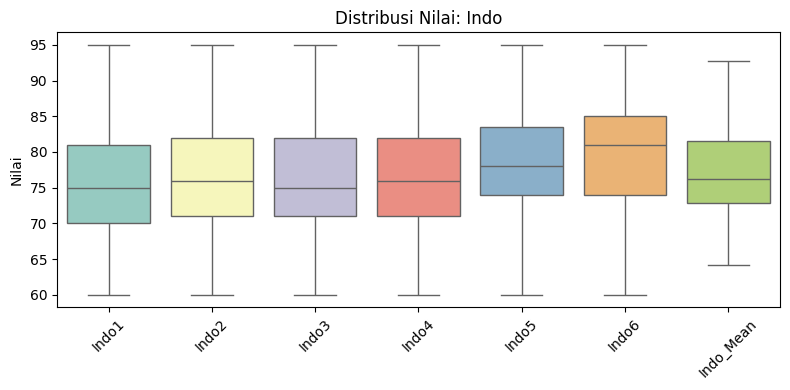

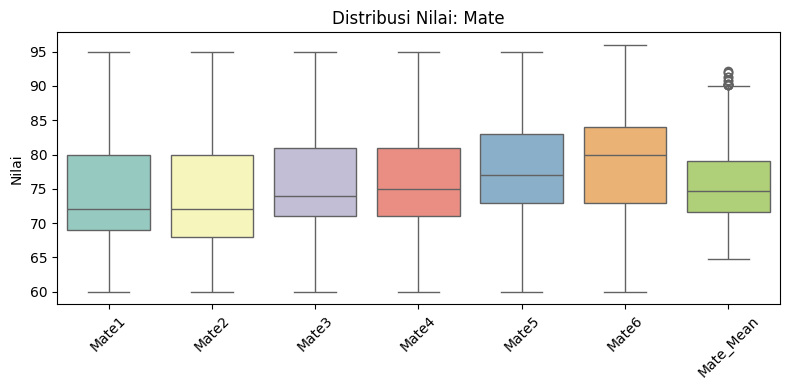

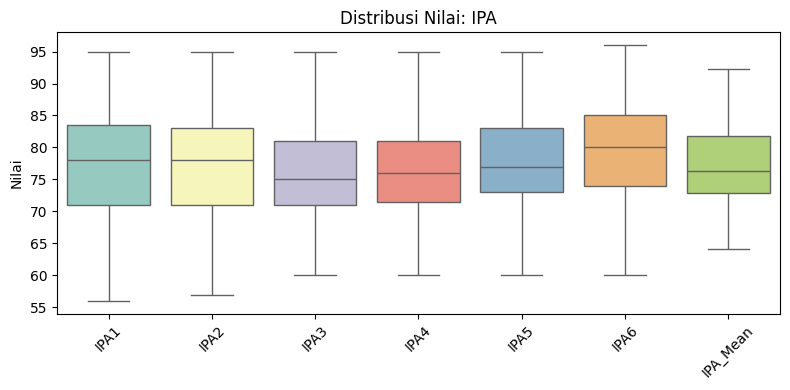

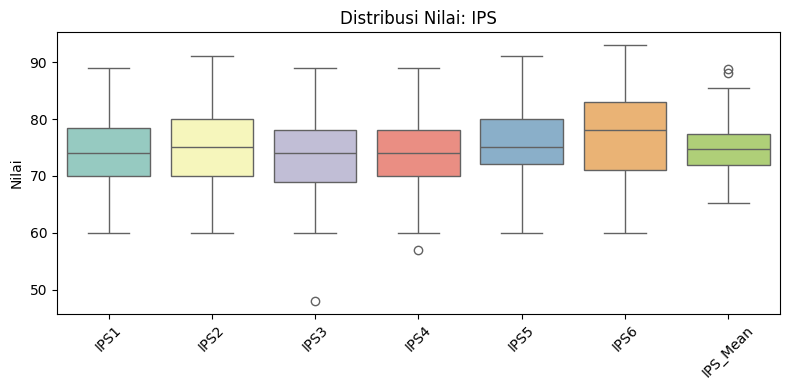

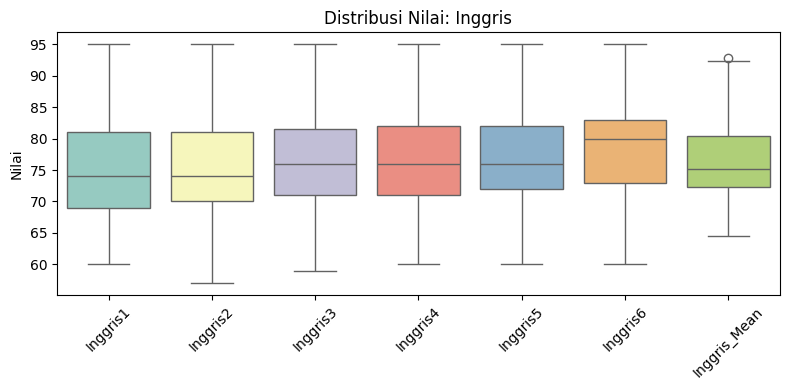

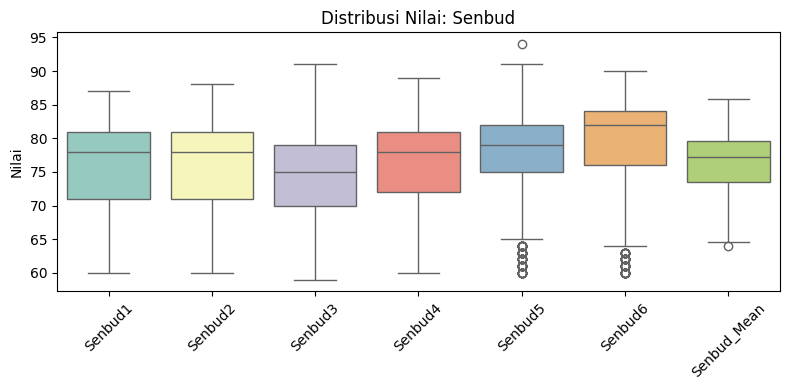

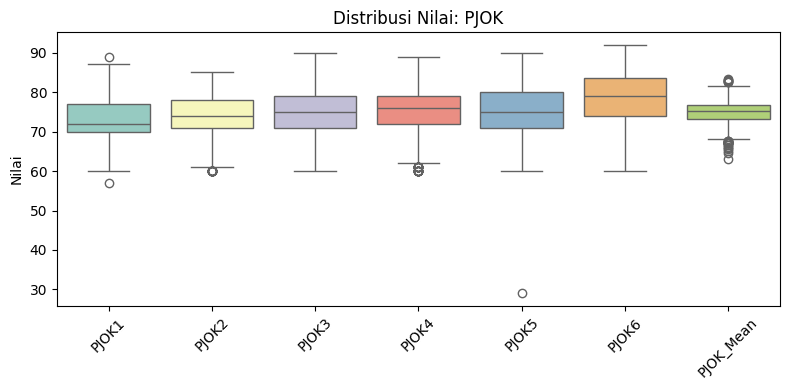

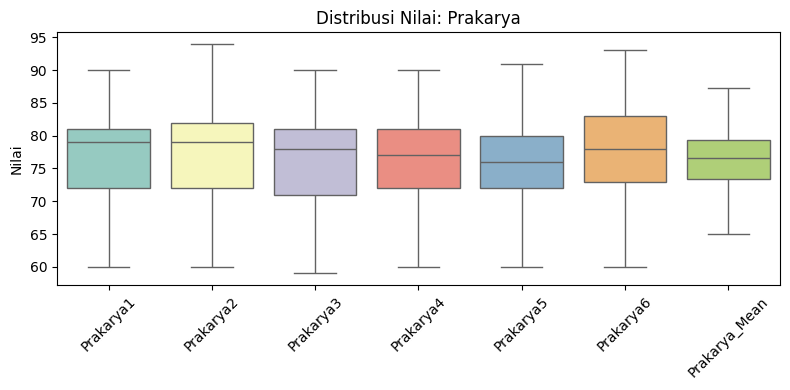

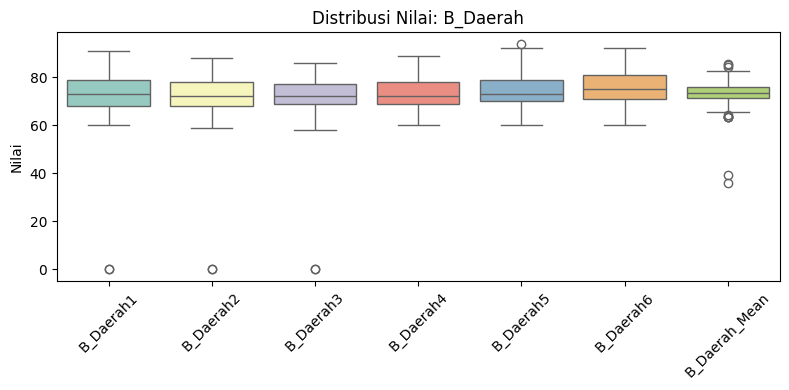

In [ ]:
for subject in subjects:
    cols = [col for col in df.columns if col.startswith(subject)]

    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df[cols], palette='Set3')
    plt.title(f'Distribusi Nilai: {subject}')
    plt.ylabel('Nilai')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Analisis Bocplot Tiap Mata Pelajaran

1. Agama:
  - Nilai cenderung tinggi (median ~85-90) dengan sedikit variasi.
  - Hampir tidak ada outlier, menunjukkan konsistensi pemahaman siswa.
2. PKN:
  - Rentang nilai lebar (60-95), menunjukkan perbedaan signifikan dalam pemahaman.
  - Beberapa outlier rendah, mungkin karena kompleksitas materi tertentu.
3. Indo:
  - Distribusi merata dengan median ~75-80.
  - Ada outlier rendah di beberapa semester (misalnya, Indo3).
4. Mate:
  - Nilai tersebar luas (60-90), menunjukkan tingkat kesulitan bervariasi.
  - Banyak outlier rendah, mengindikasikan sebagian siswa kesulitan.
5. IPA:
  - Median tinggi (~80), tetapi ada beberapa nilai ekstrem rendah.
  - Materi (misalnya, IPA3) mungkin lebih menantang.
6. IPS:
  - Nilai cenderung rendah (median ~65-70).
  - Variasi besar antar semester.
7. Inggris:
  - Nilai stabil (median ~75-80) dengan sedikit outlier.
  - Materi di semester tertentu (misalnya, Inggris6) lebih mudah dipahami daripada semester lain.
8. Senbud:
  - Nilai tinggi (median ~85) dan konsisten.
  - Kreativitas individu menyebabkan beberapa nilai ekstrem.
9. PJOK:
  - Nilai terendah dibandingkan lainnya (median ~60-70).
  - Outlier tinggi mungkin dari siswa dengan bakat olahraga.
10. Prakarya:
  - Nilai stabil (median ~75-80) dengan distribusi simetris.
  - Semester (misalnya, Prakarya4) lebih seragam nilainya.
11. B_Daerah:
  - Nilai cukup tinggi (median ~80) tetapi ada variasi di tugas lisan vs. tulisan.
  - Beberapa siswa mungkin kesulitan dengan materi tertentu (outlier rendah).

Insight Utama:
  - Mata pelajaran praktikal (PJOK, IPA) lebih bervariasi nilainya.
  - Humaniora (Agama, Senbud) cenderung stabil dengan nilai tinggi.
  - Outlier rendah perlu ditelusuri (apakah materi atau metode penilaian yang kurang jelas).

## E. Histogram

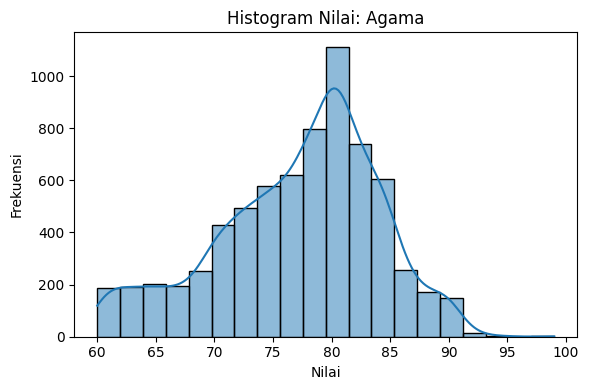

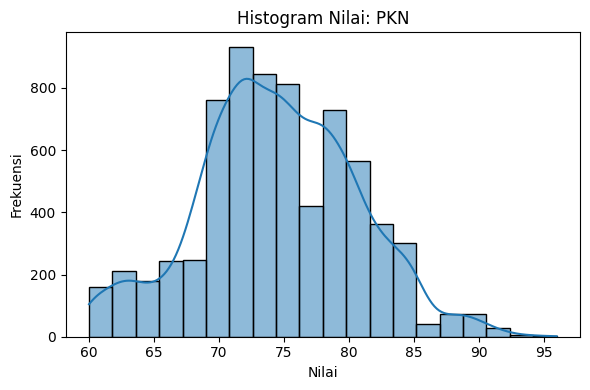

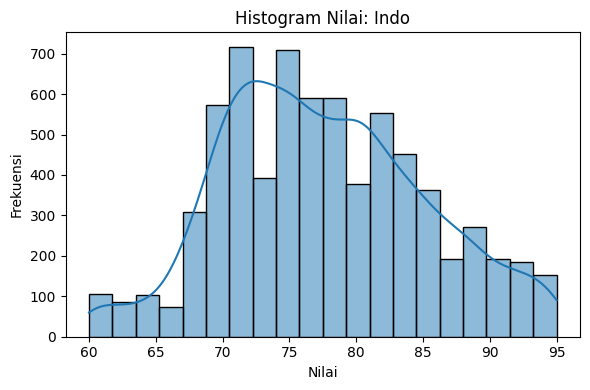

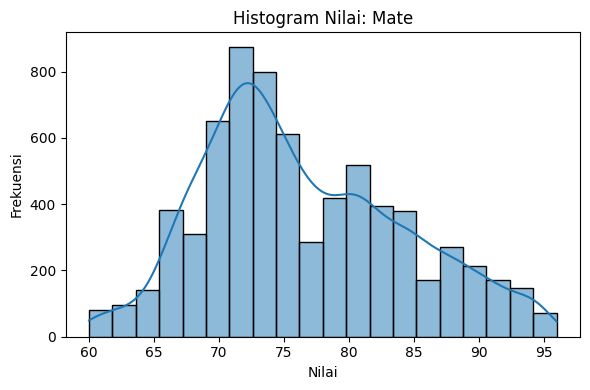

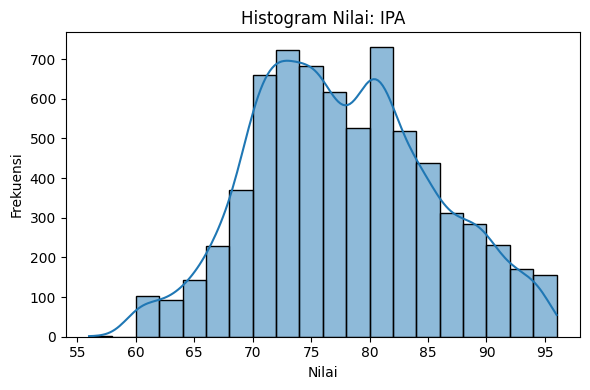

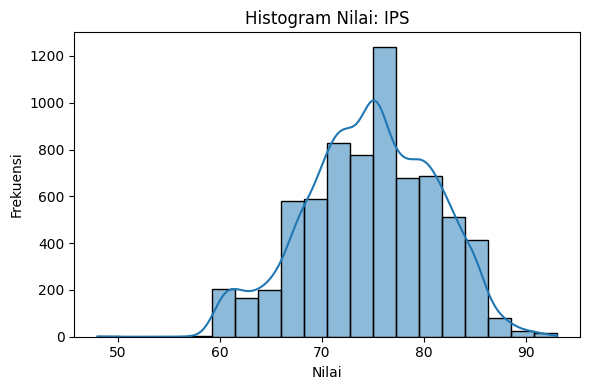

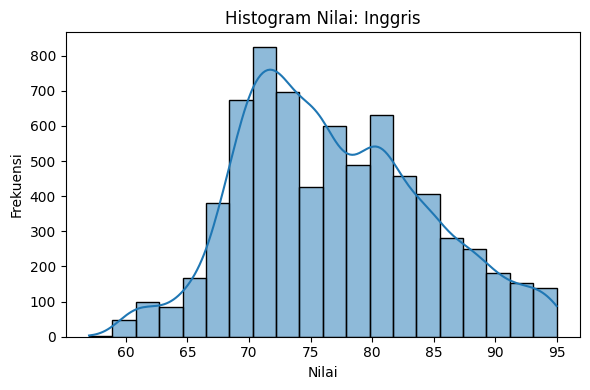

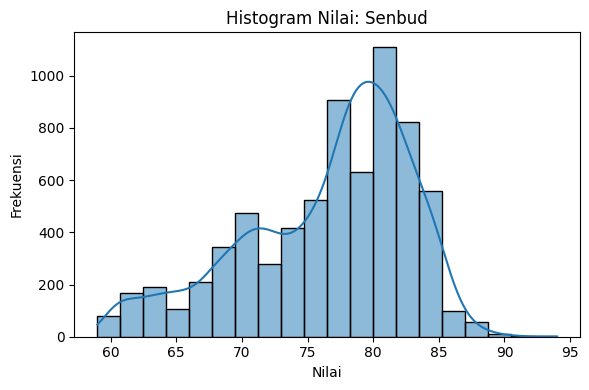

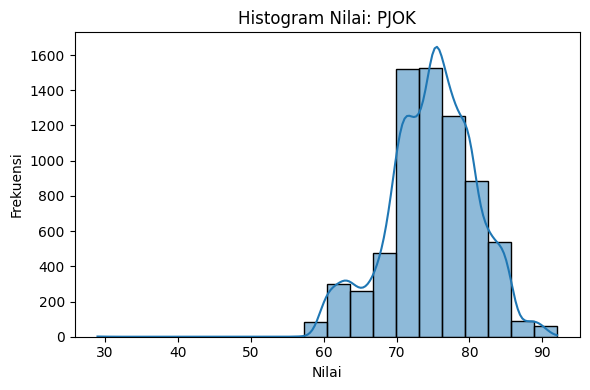

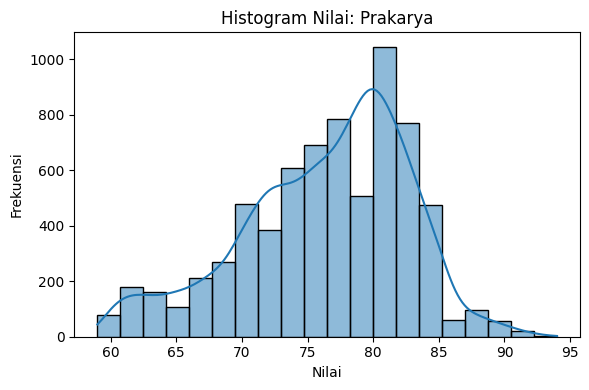

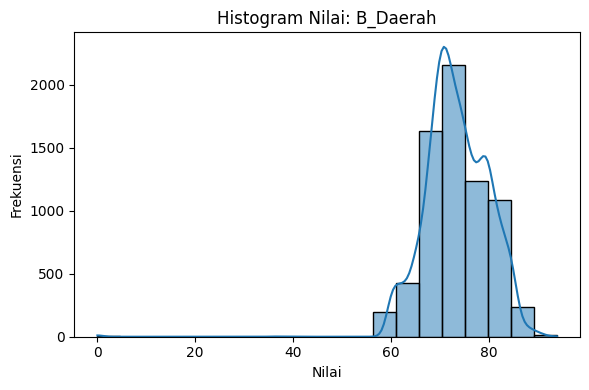

In [ ]:
for subject in subjects:
    cols = [col for col in df.columns if col.startswith(subject)]
    all_scores = df[cols].values.flatten()  # Gabungkan semua nilai di mata pelajaran tersebut

    plt.figure(figsize=(6, 4))
    sns.histplot(all_scores, bins=20, kde=True)
    plt.title(f'Histogram Nilai: {subject}')
    plt.xlabel('Nilai')
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    plt.show()

### Analisis Histogram Nilai

1. Agama:
  - Mayoritas nilai di range 80-95 (distribusi condong positif)
  - Hampir tidak ada nilai di bawah 70
  - Puncak frekuensi di 85-90
  - Penilaian relatif longgar atau materi mudah dikuasai
2. PKN:
  - Distribusi normal dengan puncak di 75-80
  - Ada ekor panjang di nilai rendah (60-70)
  - Variasi cukup besar antar siswa
  - Kemungkinan ada polarisasi pemahaman materi
3. Indo:
  - Puncak di 75-80 dengan distribusi simetris
  - Ekor pendek di nilai tinggi (90+)
  - Lebih banyak nilai rendah (60-70) dibanding Agama
  - Menunjukkan kesulitan moderat dalam penguasaan materi
4. Mate:
  - Distribusi bimodal dengan puncak di 70-75 dan 85-90
  - Banyak nilai ekstrem rendah (60-65)\
  - Polarisasi jelas antara siswa paham dan tidak paham
  - Materi mungkin terlalu teknis untuk sebagian siswa
5. IPA:
  - Distribusi normal lebar dengan puncak di 75-80
  - Ekor panjang di nilai rendah (55-70)
  - Beberapa nilai sempurna (95)
  - Praktikum mungkin menyulitkan sebagian siswa
6. IPS:
  - Distribusi miring negatif (puncak di 70-80)
  - Banyak nilai pas-pasan (60-70)
  - Rentang nilai lebih sempit dibanding mapel lain
  - Materi mungkin kurang menarik minat siswa
7. Inggris:
  - Distribusi seragam di range 70-85
  - Tidak ada dominasi nilai tertentu
  - Beberapa outlier di 60-65 dan 90+
  - Kemampuan siswa sangat bervariasi
8. Senbud:
  - Distribusi condong positif dengan puncak di 85-90
  - Hampir tidak ada nilai di bawah 70
  - Penilaian lebih subjektif berdasarkan kreativitas
  - Siswa cenderung mendapat nilai tinggi
9. PJOK:
  - Distribusi aneh dengan puncak ekstrim di 60-70
  - Banyak nilai sangat rendah (30-50)
  - Hanya sedikit nilai di atas 80
  - Kemampuan fisik sangat menentukan nilai akhir
10. Prakarya:
  - Distribusi normal dengan puncak di 75-80
  - Seimbang antara nilai rendah dan tinggi
  - Tidak ada nilai ekstrem
  - Penilaian cukup objektif berdasarkan hasil karya
11. B_Daerah:
  - Puncak ganda di 70-75 dan 85-90
  - Banyak nilai menengah (75-85)
  - Beberapa siswa kesulitan (nilai 60-65)

**Pola Umum:**
  - Mapel eksak (Mate, IPA) punya lebih banyak nilai rendah
  - Mapel seni/humaniora (Agama, Senbud) distribusi condong positif
  - PJOK menunjukkan kesenjangan kemampuan terbesar
  - Mayoritas mapel memiliki puncak di range 75-85

## F. Menampilkan tren nilai setiap pelajaran

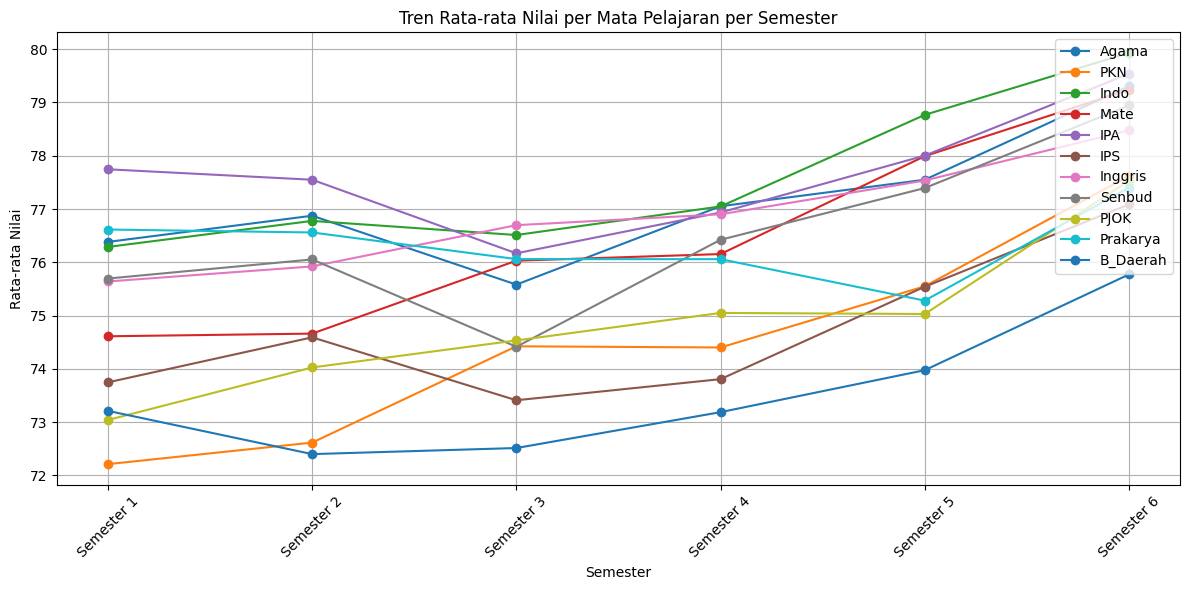

In [ ]:
subject_trends = {}

for subject in subjects:
    semester_means = []
    for i in range(1, 7):  # Semester 1 sampai 6
        col_name = f'{subject}{i}'
        if col_name in df.columns:
            semester_means.append(df[col_name].mean())
        else:
            semester_means.append(None)
    subject_trends[subject] = semester_means

# Ubah ke DataFrame
trend_df = pd.DataFrame(subject_trends, index=[f'Semester {i}' for i in range(1, 7)])

# Plot tren
plt.figure(figsize=(12, 6))
for subject in trend_df.columns:
    plt.plot(trend_df.index, trend_df[subject], marker='o', label=subject)

plt.title('Tren Rata-rata Nilai per Mata Pelajaran per Semester')
plt.xlabel('Semester')
plt.ylabel('Rata-rata Nilai')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Analisis Tren Nilai

1. Agama & PKN:
  - Nilai stabil tinggi (80-85) sepanjang semester
  - Tren sangat konsisten, sedikit fluktuasi
  - Menunjukkan penilaian lebih pada sikap daripada kompetensi
2. Indo & Inggris:
  - Ada peningkatan bertahap tiap semester
  - Lonjakan signifikan di semester 4 (mungkin metode pengajaran berubah)
  - Inggris lebih fluktuatif dibanding Bahasa Indonesia
3. Mate & IPA:
  - Nilai terendah di semester awal (65-70)
  - Peningkatan signifikan di semester 3-4
  - Semester 5-6 stabil di level 75-80
  - Siswa butuh waktu lebih lama untuk memahami konsep dasar
4. IPS:
  - Tren naik-turun tidak stabil
  - Nilai terbaik di semester 4 (mungkin terkait materi konkret)
  - Penurunan di semester 6 (bisa karena materi lebih abstrak)
5.  Senbud & Prakarya:
  - Nilai konsisten tinggi (82-88)
  - Tren sangat stabil tanpa perubahan berarti
  - Menunjukkan penilaian lebih pada proses daripada hasil
6. PJOK:
  - Nilai terendah dibanding mapel lain
  - Fluktuasi besar antar semester (tergantung jenis olahraga)
  - Puncak di semester 3 (mungkin cabang olahraga favorit)
7. B_Daerah:
  - Tren meningkat signifikan di semester 4-6
  - Adaptasi siswa membaik seiring waktu
  - Semester 1-3 masih rendah (masa penyesuaian)

**Pola Umum:**
  - Mapel eksak butuh 2-3 semester untuk menunjukkan peningkatan
  - Mapel praktikal lebih fluktuatif tergantung materi
  - Mapel hafalan/afektif nilainya paling stabil
  - Semester 4 menjadi titik balik peningkatan untuk banyak mapel

## G. Menentukan jurusan berdasakan rata-rata dan tren nilai siswa

In [ ]:
# Menghitung kemiringan grafik untuk menentukan naik atau turunnya nilai
def hitung_tren(nama_siswa, subject):
    semesters = np.array([1, 2, 3, 4, 5, 6])
    cols = [f'{subject}{i}' for i in semesters]

    # Mengambil nilai setiap siswa
    nilai = df.loc[nama_siswa, cols].values.astype(float)

    # Jika ada nilai NaN diisi dengan nilai nol
    if np.any(np.isnan(nilai)):
        return 0

    # Menghitung regresi linear
    slope, intercept, r_value, p_value, std_err = linregress(semesters, nilai)
    return slope

# diterapkan untuk setiap siswa dan setiap mata pelajaran
for subject in subjects:
    df[f'{subject}_Trend'] = df.index.map(lambda idx: hitung_tren(idx, subject))

In [ ]:
def tentukan_jurusan(row):
    # menghitung rata-rata dan tren untuk menentukan jurusan

    ipa_score = 0.7 * ((row['Mate_Mean'] + row['IPA_Mean']) / 2) + 0.3 * ((row['Mate_Trend'] + row['IPA_Trend']) / 2 * 10)
    ips_score = 0.7 * ((row['IPS_Mean'] + row['PKN_Mean']) / 2) + 0.3 * ((row['IPS_Trend'] + row['PKN_Trend']) / 2 * 10)
    bahasa_score = 0.7 * ((row['Indo_Mean'] + row['Inggris_Mean']) / 2) + 0.3 * ((row['Indo_Trend'] + row['Inggris_Trend']) / 2 * 10)

    scores = {'IPA': ipa_score, 'IPS': ips_score, 'BAHASA': bahasa_score}
    return max(scores, key=scores.get)

# Labeling
df['Jurusan'] = df.apply(tentukan_jurusan, axis=1)

In [ ]:
df['Jurusan'].value_counts()

,count
Jurusan,
IPS,347
IPA,339
BAHASA,313


### Analisis Bobot dan Rekomendasi Jurusan

1. Distribusi Penjurusan
  - IPS (346 siswa)
  - IPA (338 siswa)
  - BAHASA (313 siswa)
  - Hasil hampir seimbang, dengan IPS sedikit unggul.
2. Bobot Nilai & Alasan Pemilihan
  
  a. IPA (Eksakta)

    Bobot Terbesar: Matematika (Mate_Mean) & IPA (IPA_Mean) – 70%

    **Kenapa?**
    - Jurusan IPA butuh dasar kuat di logika & sains.
    - Tren kenaikan (slope) juga diperhitungkan (30%) untuk melihat potensi siswa yang mungkin awalnya rendah tapi terus membaik.

  b. IPS (Sosial)
    Bobot Terbesar: IPS (IPS_Mean) & PKN (PKN_Mean) – 70%

    **Kenapa?**

    - IPS fokus pada analisis sosial & hafalan, sehingga nilai PKN (kewarganegaraan) relevan.
    - Tren (30%) membantu mengidentifikasi siswa yang semakin memahami isu sosial.

  c. BAHASA (Linguistik)
    Bobot Terbesar: Bahasa Indonesia (Indo_Mean) & Inggris (Inggris_Mean) – 70%

    **Kenapa?**

    - Kemampuan linguistik stabil lebih penting daripada tren.
    - Tren (30%) dipakai untuk melihat konsistensi, bukan lonjakan nilai.


3. Kriteria Rekomendasi

  a. Siswa yang Direkomendasikan ke IPA:
    - Nilai Mate + IPA ≥ 80 (rata-rata) atau
    - Tren kenaikan kuat (slope > 1.5) meski nilai awal rendah.
    - Contoh: Siswa dengan Mate_Mean = 75 tapi Mate_Trend = +2.0 masih berpeluang masuk IPA.

  b. Siswa yang Direkomendasikan ke IPS:
    - Nilai IPS + PKN ≥ 78 atau
    - Tren analisis sosial meningkat (misal nilai IPS semester 6 jauh lebih baik dari semester 1).

  c. Siswa yang Direkomendasikan ke BAHASA:
    - Nilai Indo + Inggris ≥ 85 atau
    - Konsisten tinggi di semua semester (tren stabil, tidak fluktuatif).

**Kesimpulan:**

- IPA & IPS bersaing ketat, sementara BAHASA lebih eksklusif.
- Tren kenaikan bisa jadi penentu bagi siswa "ambang batas".

#5. Data Preparation

In [ ]:
# Hilangkan kolom yang tidak diperlukan
df = df.drop(columns=["Nama", "NIS", "Ekstrakurikuler", "Absen"])

# Kolom fitur (hanya mean dan trend nilai)
feature_cols = []
for subject in subjects:
    feature_cols.extend([f'{subject}_Mean', f'{subject}_Trend'])

# Pisahkan fitur dan target
X = df[feature_cols]
y = df['Jurusan']

# Scalling data menggunakan MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(pd.DataFrame(X_scaled, columns=feature_cols).head())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Agama_Mean  Agama_Trend  PKN_Mean  PKN_Trend  Indo_Mean  Indo_Trend  \
0    0.407186     0.451524     0.720   0.703125   0.251462    0.596825   
1    0.491018     0.423823     0.664   0.712500   0.280702    0.612698   
2    0.359281     0.484765     0.560   0.596875   0.198830    0.549206   
3    0.526946     0.529086     0.672   0.778125   0.362573    0.765079   
4    0.335329     0.545706     0.496   0.653125   0.187135    0.523810   

   Mate_Mean  Mate_Trend  IPA_Mean  IPA_Trend  ...  Inggris_Mean  \
0   0.268293    0.527066  0.195266   0.595870  ...      0.382353   
1   0.359756    0.638177  0.260355   0.663717  ...      0.376471   
2   0.146341    0.470085  0.218935   0.578171  ...      0.211765   
3   0.414634    0.823362  0.390533   0.516224  ...      0.535294   
4   0.213415    0.507123  0.207101   0.536873  ...      0.282353   

   Inggris_Trend  Senbud_Mean  Senbud_Trend  PJOK_Mean  PJOK_Trend  \
0       0.476923     0.618321      0.388571   0.710744    0.707101   
1     

#6. Modelling

## A. Pertimbangan Pemilihan Model

Setelah proses EDA yang menunjukkan karakteristik data, selanjutnya akan dilakukan pemilihan model yang harus memenuhi kriteria berikut:

1. Setiap mata pelajaran punya pola distribusi dan tren yang berbeda. **Model harus mampu mampu menangani pola non-linear dan interaksi antar fitur.**

2. Terdapat mata pelajaran yang memiliki outlier rendah dan variasi nilai antar semester. **Model harus robust terhadap outlier dan noise dalam data.**

3. Keputusan jurusan bergantung pada kombinasi dan bobot dari nilai mapel tertentu + tren nilai. **Model harus mampu menangani fitur numerik dan interaksi kompleks tanpa asumsi linearitas.**

Terdapat tiga kandidat model yang dapat menjadi pertimbangan, yaitu:

1. **XGBoost**

    Kelebihan: Berpotensi memiliki performa tinggi

    Kekurangan: Sulit melakukan interpretasi model

2. **Logistic Regression**

    Kelebihan: Interpretasi sangat mudah dijelaskan, terutama kepada audiens non-data

    Kekurangan: Berpotensi memiliki performa rendah

3. **Random Forest Classifier**

    Kelebihan: Model lebih balance dengan performa baik dan interpretasi jelas.

    Kekurangan: Jika menyasar salah satu target (performa atau interpretasi), maka model lain lebih unggul.

Berdasarkan beberapa pertimbangan yang disampaikan, diputuskan model yang akan digunakan yaitu **Random Forest Classifier** dengan alasan karena model tersebut balance untuk mencapai target proyek ini.

## B. Pelatihan Model Random Forest Classifier

### Inisialisasi dan latih model

In [ ]:
#Inisialisasi model dan parameter awal
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt'
)

In [ ]:
# fitting model
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

Training Random Forest model...


RandomForestClassifier(random_state=42)

### Prediksi Model

In [ ]:
# tahap prediksi model
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

#7. Evaluasi

## A. Classification Report

In [ ]:
# akurasi prediksi model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 0.8500


In [ ]:
# Print classification report
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_test))


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

      BAHASA       0.90      0.72      0.80        65
         IPA       0.86      0.89      0.87        61
         IPS       0.81      0.93      0.87        74

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



In [ ]:
# Print detail metrik
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nWeighted Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Weighted Metrics:
Precision: 0.8555
Recall: 0.8500
F1-Score: 0.8479


### Analisis Hasil Classification Report

    1. Testing Accuracy: 85%
Model memiliki performa yang cukup baik, mampu mengklasifikasikan jurusan dengan benar sebanyak 85 dari 100 siswa secara rata-rata.

    2. Training Accuracy: 100%
Ini menandakan model kemungkinan mengalami overfitting, tetapi tetap berhasil menjaga generalisasi cukup baik di testing set (gap 15%).

**Temuan Masalah**

Model tidak sensitif terhadap siswa BAHASA (recall = 0.72). Ketika dilakukan prediksi, sistem bisa salah menentukan penjurusan siswa ke jurusan lain.


## B. Confusion Matrix Visualization


=== CONFUSION MATRIX ===


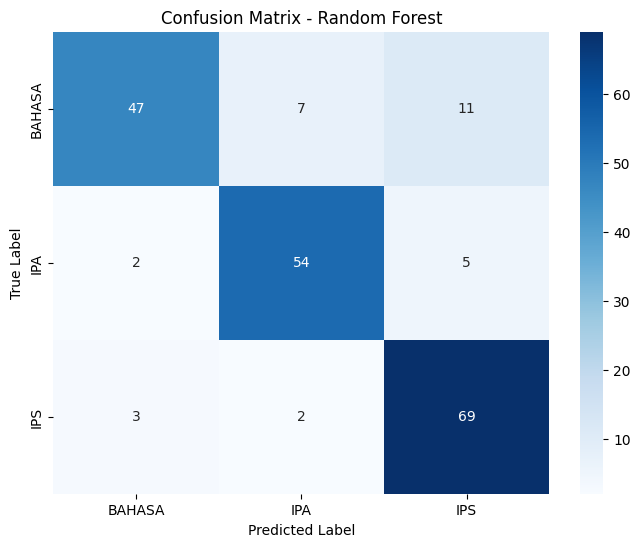

In [ ]:
print("\n=== CONFUSION MATRIX ===")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Interpretasi Hasil Confusion Matrix

**Analisis Per Baris (Berdasarkan True Label)**

1. Actual BAHASA

	•	47 siswa diklasifikasikan dengan benar sebagai BAHASA.

	•	18 siswa (7 + 11) salah prediksi ke IPA dan IPS.

	•	Recall BAHASA = 47 / 65 ≈ 0.72

    Cukup rendah, berarti banyak siswa BAHASA tercampur ke IPA dan IPS.

2. Actual IPA

	•	54 siswa diklasifikasikan dengan benar sebagai IPA.

	•	7 siswa (2 + 5) salah prediksi ke BAHASA dan IPS.

	•	Recall IPA = 54 / 61 ≈ 0.89

    Sangat baik. Model sangat tepat dan sensitif mengenali siswa IPA.

3. Actual IPS

	•	69 siswa diklasifikasikan dengan benar sebagai IPS.

	•	5 siswa (3 + 2) salah prediksi ke BAHASA dan IPA.

	•	Recall IPS = 69 / 74 ≈ 0.93

    Paling tinggi. Model sangat kuat dalam mengenali siswa IPS.

---

**Analisis Per Kolom (Berdasarkan Predicted Label)**

1. Predicted BAHASA (52 total)

	•	47 benar (dari BAHASA), 2 dari IPA, 3 dari IPS.

	•	Precision BAHASA = 47 / 52 ≈ 0.90

    model jarang salah menyebut orang lain sebagai BAHASA, tapi kurang bagus dalam menemukan semua siswa BAHASA.

2. Predicted IPA (63 total)

	•	54 benar (dari IPA), 7 salah (7 dari BAHASA dan IPS).

	•	Precision IPA = 54 / 63 ≈ 0.86

3. Predicted IPS (85 total)

	•	69 benar (dari IPS), 16 salah (11 dari BAHASA dan 5 dari IPA).

	•	Precision IPS = 69 / 85 ≈ 0.81

    Ini kelas dengan precision terendah, karena banyak siswa lain salah dikira IPS.

## C. Feature Importance

In [ ]:
print("\n=== FEATURE IMPORTANCE ===")

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))


=== FEATURE IMPORTANCE ===
Top 10 Most Important Features:
          feature  importance
4       Indo_Mean    0.117053
12   Inggris_Mean    0.107842
6       Mate_Mean    0.101038
8        IPA_Mean    0.090037
3       PKN_Trend    0.064444
9       IPA_Trend    0.049235
14    Senbud_Mean    0.048390
7      Mate_Trend    0.046110
0      Agama_Mean    0.045109
13  Inggris_Trend    0.043843


### Interpretasi Hasil Feature Importance

Top 10 Fitur Terpenting

**1. Indo_Mean (0.117053) - Paling Berpengaruh**
- **Mata Pelajaran**: Bahasa Indonesia (rata-rata nilai)
- **Interpretasi**: Kemampuan bahasa Indonesia menjadi faktor dominan dalam penentuan penjurusan
- **Alasan**: Bahasa Indonesia adalah fondasi komunikasi dan pemahaman di semua jurusan

**2. Inggris_Mean (0.107842)**
- **Mata Pelajaran**: Bahasa Inggris (rata-rata nilai)
- **Interpretasi**: Kemampuan bahasa asing sangat penting untuk semua penjurusan
- **Dampak**: Menunjukkan kemampuan adaptasi dan komunikasi global

**3. Mate_Mean (0.101038)**
- **Mata Pelajaran**: Matematika (rata-rata nilai)
- **Interpretasi**: Logika dan kemampuan analitis fundamental untuk IPA dan IPS
- **Peran**: Indikator kemampuan berpikir sistematis

**4. IPA_Mean (0.090037)**
- **Kategori**: Rata-rata mata pelajaran IPA
- **Interpretasi**: Gabungan performa sains (Fisika, Kimia, Biologi)
- **Fungsi**: Pembeda utama untuk penjurusan IPA

**5. PKN_Trend (0.064444)**
- **Mata Pelajaran**: Pendidikan Kewarganegaraan (tren nilai)
- **Interpretasi**: Pola perkembangan dalam pemahaman civic education
- **Makna**: Stabilitas dan konsistensi belajar siswa

## Insight Kunci

**Pola Dominasi Bahasa**
- **2 dari 3 fitur teratas** adalah mata pelajaran bahasa
- **Implikasi**: Kemampuan komunikasi menjadi prediktor utama kesuksesan akademik
- **Rekomendasi**: Perkuat fundasi bahasa untuk semua siswa

**Keseimbangan Mean vs Trend**
- **7 fitur "Mean"** vs **3 fitur "Trend"**
- **Interpretasi**: Rata-rata nilai lebih penting daripada tren perkembangan
- **Makna**: Konsistensi performa lebih diutamakan daripada peningkatan drastis

**Distribusi Bobot yang Merata**
- **Rentang**: 0.043 - 0.117 (tidak ada fitur yang terlalu dominan)
- **Interpretasi**: Model mempertimbangkan multiple aspek secara seimbang
- **Keunggulan**: Prediksi tidak bias pada satu mata pelajaran saja

## Rekomendasi Praktis

**Untuk Pendidik**
1. **Prioritaskan** pengembangan kemampuan bahasa (Indonesia & Inggris)
2. **Perkuat** fondasi matematika sebagai dasar logika
3. **Monitor** tren PKN untuk mengukur stabilitas belajar siswa

**Untuk Siswa**
1. **Fokus** pada penguasaan bahasa sebagai modal utama
2. **Jangan abaikan** matematika meski tidak ingin ke IPA
3. **Pertahankan** konsistensi nilai di semua mata pelajaran

**Untuk Sistem Pendidikan**
- Model menunjukkan pentingnya **pendekatan holistik** dalam penilaian
- **Tidak ada mata pelajaran** yang bisa diabaikan sepenuhnya
- **Kemampuan komunikasi** terbukti sebagai soft skill terpenting

## D. Cross Validation

In [ ]:
print("\n=== CROSS VALIDATION ===")

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


=== CROSS VALIDATION ===
Cross-validation scores: [0.80625    0.83125    0.8375     0.84375    0.79874214]
Mean CV Score: 0.8235 (+/- 0.0355)


### Interpretasi Hasil Cross Validation

**1. Mean CV Score = 0.8235**

- Rata-rata akurasi 5-fold CV sebesar 82.35% sangat dekat dengan akurasi testing aktual 85%.
- Ini menandakan bahwa model awal memiliki kapasitas generalisasi yang cukup baik, meskipun belum optimal.

**2. Standard Deviation = ±0.0355**

- Deviasi standar sebesar 3.55% menandakan stabilitas model cukup baik di berbagai subset data.
- Tidak ada variasi performa yang ekstrem antar fold → model awal tidak terlalu rentan terhadap fluktuasi partisi data.

**3. Distribusi Skor antar Fold**

| Fold | Skor Akurasi |
|------|--------------|
| 1    | 0.80625      |
| 2    | 0.83125      |
| 3    | 0.83750      |
| 4    | 0.84375      |
| 5    | 0.79874      |

- Fold dengan skor terendah (Fold 5: ~0.798) masih berada dekat dengan ambang performa layak.
- Fold dengan skor tertinggi (Fold 4: ~0.844) mendekati akurasi uji aktual (85%), menandakan bahwa kemampuan generalisasi model sudah cukup mapan, namun masih punya ruang untuk ditingkatkan.

**Kesimpulan Awal (Pre-Tuning)**

Model Random Forest sebelum tuning sudah menunjukkan performa baik, dengan:
- Akurasi Uji: 85.0%
- Mean Cross-Validation Score: 82.35%
- Deviasi rendah: ±3.5%
- Namun, ada potensi untuk meningkatkan:
- Recall pada kelas BAHASA.
- Stabilitas antar fold agar model semakin robust.
- Optimasi hiperparameter untuk mengeksplorasi kemungkinan struktur pohon yang lebih efisien.


## E. Hyperparameter Tuning

### Mendefiniskan Parameter Grid untuk Tuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Melakukan Grid Search

In [ ]:
print("Performing Grid Search...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Performing Grid Search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.8198


### Evaluasi Model Final dengan Parameter Terbaik

In [ ]:
print("\n=== FINAL MODEL EVALUATION ===")

# Train final model dengan best parameters
final_rf_model = grid_search.best_estimator_
final_y_pred = final_rf_model.predict(X_test)

# Final evaluation
final_accuracy = accuracy_score(y_test, final_y_pred)
final_precision = precision_score(y_test, final_y_pred, average='weighted')
final_recall = recall_score(y_test, final_y_pred, average='weighted')
final_f1 = f1_score(y_test, final_y_pred, average='weighted')

print("Final Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")

print("\n--- Final Classification Report ---")
print(classification_report(y_test, final_y_pred))


=== FINAL MODEL EVALUATION ===
Final Model Performance:
Accuracy: 0.8500
Precision: 0.8584
Recall: 0.8500
F1-Score: 0.8488

--- Final Classification Report ---
              precision    recall  f1-score   support

      BAHASA       0.92      0.74      0.82        65
         IPA       0.87      0.87      0.87        61
         IPS       0.79      0.93      0.86        74

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



### Interpretasi Hasil Tuning Parameter Terbaik

**Best Parameter**

    {'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 100}

**1. max_depth = None**

Definisi:

Tidak ada batasan maksimum terhadap kedalaman setiap decision tree dalam ensemble.

Implikasi:

- 	Memberikan fleksibilitas maksimal dalam membentuk pembelahan (splits), memungkinkan pohon mempelajari struktur relasi fitur-target secara mendalam.
- Namun, juga meningkatkan risiko overfitting, terutama jika tidak dikendalikan oleh parameter lain seperti min_samples_split atau min_samples_leaf.

**2. min_samples_leaf = 1**

Definition:

Jumlah minimum sampel yang diperlukan untuk berada pada satu daun (terminal node) adalah 1.

Implikasi:

- Memberikan model granularitas maksimum dalam membentuk keputusan klasifikasi, memungkinkan identifikasi outlier dan minor classes.
- Dalam model single-tree seperti Decision Tree biasa, hal ini akan sangat rentan terhadap high variance. Namun dalam Random Forest, variansi dikurangi secara substansial oleh mekanisme ensemble, sehingga lebih aman.

**3. min_samples_split = 5**

Definition:

Minimum jumlah sampel yang dibutuhkan dalam satu node untuk memicu pembelahan selanjutnya.

Implikasi:

- Membatasi pertumbuhan pohon terhadap pembelahan yang tidak signifikan secara statistik.
- Secara efektif bertindak sebagai mekanisme regularisasi, menghindari pemecahan node yang berdasarkan pada noise atau variasi tidak substansial.

**4. n_estimators = 100**

Definition:

Jumlah pohon keputusan (decision trees) yang dibentuk dalam ensemble.

Theoretical Implication:

- Jumlah pohon yang lebih besar secara umum meningkatkan stabilitas model dan memperkecil variansi prediksi.
- Namun peningkatan jumlah pohon juga akan menaikkan kompleksitas komputasi dan waktu pelatihan.

---

**Best Cross-Validation Score: 0.8198**

Nilai ini menunjukkan estimasi kinerja model terhadap data tak terlihat, dihitung melalui k-fold cross-validation.

Dengan rata-rata akurasi 81.98%, model menunjukkan kemampuan generalisasi yang baik, menunjukkan bahwa parameter hasil tuning memfasilitasi keseimbangan optimal antara overfitting dan underfitting.



## F. Komparasi Model

In [ ]:
print("\n=== MODEL COMPARISON ===")

comparison_df = pd.DataFrame({
    'Model': ['Initial RF', 'Tuned RF'],
    'Accuracy': [test_accuracy, final_accuracy],
    'Precision': [precision, final_precision],
    'Recall': [recall, final_recall],
    'F1-Score': [f1, final_f1]
})

print(comparison_df)


=== MODEL COMPARISON ===
        Model  Accuracy  Precision  Recall  F1-Score
0  Initial RF      0.85   0.855532    0.85  0.847888
1    Tuned RF      0.85   0.858448    0.85  0.848810


### Interpretasi Komparasi Model Sebelum dan Sesudah Tuning

**1.	Stabilitas Akurasi:**

Meskipun tuning dilakukan, akurasi model tetap stabil di 85%, menandakan bahwa performa keseluruhan model terhadap data tidak berubah secara signifikan dari sisi prediksi benar secara umum.

**2.	Peningkatan Precision:**

Precision mengalami sedikit peningkatan setelah tuning, dari 0.8555 menjadi 0.8584. Hal ini menunjukkan bahwa model hasil tuning sedikit lebih baik dalam menghindari false positives. Artinya, model menjadi sedikit lebih selektif dan tepat saat memprediksi kelas tertentu.

**3.	Konstanta Recall:**

Recall tetap pada angka 0.8500, yang berarti kemampuan model dalam mengidentifikasi seluruh instance positif (true positives) tetap tidak berubah. Ini menunjukkan bahwa tuning tidak memperburuk kemampuan deteksi secara menyeluruh.

**4.	Kenaikan Minor F1-Score:**

F1-score naik dari 0.8479 menjadi 0.8488, meskipun tipis, ini tetap menunjukkan bahwa model menjadi sedikit lebih seimbang dalam precision dan recall setelah tuning dilakukan.

SAVE MODEL

In [ ]:
print("\n=== SAVING MODEL ===")
joblib.dump(final_rf_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved successfully!")

print("\n=== MODELING & EVALUATION COMPLETED ===")


=== SAVING MODEL ===
Model and scaler saved successfully!

=== MODELING & EVALUATION COMPLETED ===


In [ ]:
import pickle

# Simpan model Random Forest
pickle.dump(final_rf_model, open("rf_model.pkl", "wb"))

# Simpan StandardScaler
pickle.dump(scaler, open("standard_scaler.pkl", "wb"))

print("Model Random Forest dan StandardScaler berhasil disimpan.")